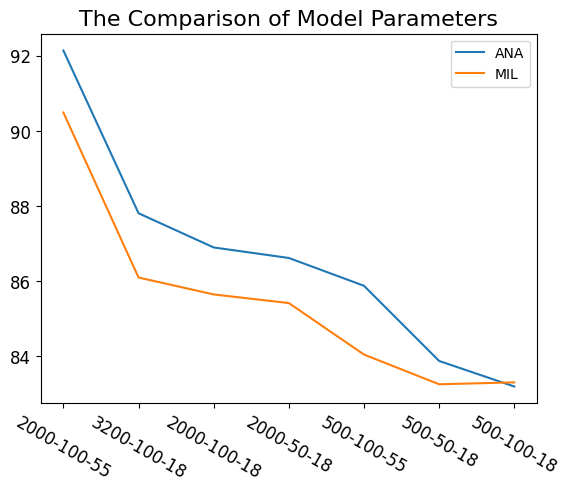

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


col = ['2000-100-55',
'500-100-55',
'3200-100-18',
'2000-100-18',
'500-100-18',
'2000-50-18',
'500-50-18'
]

ana = [92.14,
85.88,
87.81,
86.90,
83.20,
86.62,
83.88
]

mil = [90.49,
84.05,
86.10,
85.65,
83.31,
85.42,
83.26
]

np.array([ana, mil]).T

df = pd.DataFrame(np.array([ana, mil]).T, columns=['ANA', 'MIL'], index=col)
df.sort_values('ANA', ascending=False, inplace=True)
ax = df.plot(rot=330, title='The Comparison of Model Parameters', fontsize=12) # 
fig = ax.get_figure()
ax.title.set_size(16)
fig.savefig('compareparas.png', dpi=300, bbox_inches='tight')

In [14]:
import os
import time
import datetime
import numpy as np
import pandas as pd
from utils2.users import load_users, select_post_ana, combine_users
from utils2.metrics import find_optimal_cutoff, get_max_acc
from attention import AttentionWithContext
#from keras.layers import AttentionWithContext
from keras.optimizers import AdaMod
from utils2.tokeniser import Tokenizer, token_text
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from numpy.random import seed
from tensorflow import set_random_seed
from nltk.tokenize import TweetTokenizer
from utils2 import split_data
from keras.models import load_model
import glob
import tensorflow as tf
from keras import backend as K
from keras.models import Model

ModuleNotFoundError: No module named 'keras.attention'

In [ ]:
SEED = 1
seed(SEED)
set_random_seed(SEED)

POST_SIZE = 100
MAX_POST_LENGTH = 55
MAX_POSTS = 2000
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100
NB_DEPRESS = 1984

DIR = '../data/'

inputs, labels = load_users(DIR, POST_SIZE, MAX_POSTS, NB_DEPRESS, True)
control = inputs[inputs.label == 0].reset_index(drop=True)
depress = inputs[inputs.label == 1].reset_index(drop=True)

fold = 0
results = []
MODEL_FOLDER = "2020-02-23 18-04p2000-55-em100"
MODEL_FOLDER = "../results/ana/{}/".format(MODEL_FOLDER)
MODEL_FOLDER = sorted(glob.iglob(os.path.join(MODEL_FOLDER, '*')), key=os.path.getctime, reverse=False)

liwc = pd.read_csv(DIR + 'LIWC2015-pron.csv', encoding='utf8')

i = 0
for data_index in split_data.split(depress, 4):

    data_fold = depress[depress.userid.isin(data_index)]

    print(data_index[:10])
    print(data_fold.head())

    combine, labels = combine_users(control, data_fold)
    combine = combine.merge(liwc, on=['tweetid', 'userid'])
    inputs, i_inputs, labels = select_post_ana(combine, labels, MAX_POSTS)

    del combine, data_fold

    # transform Y to categories
    print(labels.label.value_counts())
    labels = labels.label.values
    labels = to_categorical(np.asarray(labels))

    print('Input number: ', len(inputs))
    print('Label number: ', len(labels))

    alltexts = np.hstack(np.array(inputs).flatten())
    # alltexts = np.hstack(np.array(inputs))

    print('Tokenizing text')

    start = time.time()
    tknzr = TweetTokenizer(reduce_len=True)
    alltexts = [tknzr.tokenize(text.lower()) for text in alltexts]

    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(alltexts)
    word_index = tokenizer.word_index
    print('Total %s unique tokens.' % len(word_index))
    elapsed_time_fl = (time.time() - start)
    print(elapsed_time_fl)

    print('Transforming text to input sequences')
    start = time.time()
    data = np.zeros((len(inputs), MAX_POSTS, MAX_POST_LENGTH), dtype='int32')
    i_data = np.zeros((len(inputs), MAX_POSTS, len(i_inputs[0][0])), dtype='float')

    for i, posts in enumerate(inputs):
        for j, post in enumerate(posts):
            if j < MAX_POSTS:
                # sequences = tokenizer.lists_to_sequences([post])
                sequences = tokenizer.texts_to_sequences([post])
                seq_data = pad_sequences(sequences, maxlen=MAX_POST_LENGTH)
                data[i, j] = seq_data
                i_data[i, :len(i_inputs[i])] = i_inputs[i]
    elapsed_time_fl = (time.time() - start)
    print(elapsed_time_fl)

    del inputs, alltexts, i_inputs

    print('Finished loading data')

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
    for train_index, test_index in skf.split(np.asarray(data), labels[:, 1]):
        np.random.seed(0)
        tf.set_random_seed(0)
        sess = tf.Session(graph=tf.get_default_graph())
        K.set_session(sess)

        print(datetime.datetime.now())
        X_train, x_val = data[train_index], data[test_index]
        Xi_train, xi_val = i_data[train_index], i_data[test_index]
        y_train, y_val = labels[train_index], labels[test_index]

        model_name = sorted(glob.iglob(os.path.join(MODEL_FOLDER[fold], '*.hdf5')), key=os.path.getctime, reverse=True)[0]
        model = load_model(model_name,
                           custom_objects={'AttentionWithContext': AttentionWithContext, 'optimizer': AdaMod})
        break
    break



The number of control:  1699
The number of depress:  1984
Control shape:  (3944945, 3)
Depress shape:  (4996621, 3)
Selecting users with at least 100 posts
Control users:  1699
-----------11.865196228027344-----------
Depress users:  1984
-----------15.707852840423584-----------
Labelling
[ 780078428687065089            25567061           416684112
           608725707  912541969968066560          2700680921
          2329059770 1064934140007538688            43903078
            16656127]
                  tweetid   userid  \
3234  1143666788107866112  5882452   
3235  1143666924246560768  5882452   
3236  1143664692679720961  5882452   
3237  1143661172891066370  5882452   
3238  1143669737378893824  5882452   

                                                  clean  label  
3234  user user i've always felt like i was kind of ...      1  
3235  user user i cannot function without my morning...      1  
3236  user way too much of what you're describing so...      1  
3237  user betwe

In [ ]:
for i in model.layers:
    print(i.name)

input_3
time_distributed_1
input_2
concatenate_1
batch_normalization_1
dropout_3
bidirectional_2
dropout_4
attention_with_context_2
dropout_5
dense_2


In [ ]:
from sklearn.preprocessing import minmax_scale


def change_post_prob(prob):
    A1 = np.array(prob[0, :, 1])
    avg = A1.mean()
    sd = A1.std()
    
    for i in range(len(A1)):
        if A1[i] <= (avg - sd):
            A1[i] = (avg - sd)
        if A1[i] >= (avg + sd):
            A1[i] = (avg + sd)
    
    return minmax_scale(A1)

In [ ]:
idx = 5 # 10

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = model.get_layer('attention_with_context_2').output
testmodel = Model(model.input, testmodel)
layer_extract = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])

# get probability from the post classification model
testmodel = model.get_layer('time_distributed_1').output
testmodel = Model(model.input, testmodel)
post_prob = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])
post_prob = change_post_prob(post_prob)

get_layer_output = K.function([model.layers[0].input, model.layers[2].input, K.learning_phase()], [model.layers[7].output]) # get layer before attn
test_seq = tf.convert_to_tensor(x_val[idx:idx+1])
test_seqi = tf.convert_to_tensor(xi_val[idx:idx+1])
out = get_layer_output([test_seq, test_seqi])[0]

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]]))

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))


[0. 1.]
[[0.01792228 0.98207766]]
1505   0.00032144785   0.0 talk about adding insult to injury . url
687   0.0   1.6599894e-05 user would love more html customization ability for better formatting of data and individual entry views .
219   0.0   1.7091632e-05 user url url url url url flexible .
1269   0.0   1.758337e-05 user user done w / , authenticity . doesn ’ t meant a token figure here or there . but rather being intentional with every piece of creative
723   0.0   1.8045306e-05 downtown chandler , arizona . happy friday all ! ! url
218   0.0   2.2307038e-05 i am getting convinced that the suns don ’ t know what they ’ re doing . brandon knight . eric bledsoe . alvin . jeff . earl watson .
203   0.0   2.2485852e-05 phoenix , the once shinning sports city in the world is now a joke . url
1268   0.0   2.412498e-05 user user i really feel like being intentional in featuring all different body types should be practiced just as featuring different races .
1504   0.5381027   2.5838614e

447   0.06393564   0.0003171414 today is my day to load up on carbs and sugar after going number days with just veggies and protein . red robin all the way ! ! ! url
1508   0.45581633   0.00031778216 user it ’ s number % .
1499   0.0   0.00031793118 love the legacy that user has created for our family and that he is so involved in my life and the life of my boys . love you dad . url
1299   0.43002647   0.00032101572 user i signed up for the base level at $ number month paid annually . the unlimited is $ number month paid annually - but pricing goes up tonight , i think xnumber definitely worth it if you buy numbernumber stock video clips a year .
1477   0.0043691397   0.00032243133 user thank you ! this one is pretty good at number - wanted the hybrid but couldn ’ t justify the expense .
1663   0.5086693   0.0003272742 argument for or against putting hashtags in the first comment after your instagram post caption . what do you know about it ? go ! ! ! <hashtag> instagram <hashtag> <has

491   0.025386631   0.0013362318 it ’ s friday ! ! what was your biggest win this past week ? i would really love to hear and celebrate with you ! <hashtag> onlinebusiness <hashtag> celebrate url
1206   0.06505346   0.0013368428 i ’ ve been watching the world war ii in color documentary on netflix for the past month . it ’ s really good ... and really lengthy .
1856   0.28048933   0.0013370216 [ number / number ] allow the idea to come alive and mature even if there is only one aspect of that idea that may work . just some thoughts for a wednesday :-) anything else you can add to it ?
1076   0.4559521   0.0013380796 user i love it every time you send a photo of your work ! happy friday , andrew !
1536   0.7256035   0.001342982 user can you provide instruction on how to do that and where it shows up in the report view ? ?
739   0.0   0.0013467222 mark ’ s talking about real estate - but he ’ s really talking about just begin an awesome person to others in the game of life ! url
1051   0

1369   0.55546254   0.0038581938 user bahahahahaha
504   0.21538723   0.0038586408 couldn't have said it better myself . url
1519   0.755011   0.0038814247 user user user what about ? ? he will be out of a job .
1042   0.86261016   0.0038821548 it's disgusting how much money is left on the table for lack of follow up . for crying out loud ... call the back ! ! ! <hashtag> onlinebusiness
1657   0.5838961   0.0038867295 user the thing i take away is not quitting social media altogether , but choosing to quit a particular network . i think that ’ s the more worrisome takeaway because , you ’ re right , what they say vs reality is not something i ’ d bet a lunch on .
1448   0.60770065   0.0038972497 user hahahahahahaha
763   0.6193128   0.0039047152 user haha !
352   0.029127955   0.0039116293 successful communication is all about empathy . before you say anything assume no one cares - adjust your message to compel them to care . url
847   0.6536898   0.0039149076 user user boy has he ever

1988   0.99999994   0.012315854 so , at user is not worth it . took about number minutes to get my order and then ask if could bring out some ketchup ... number minutes later , no ketchup .
1443   0.264834   0.012352183 user support from folks ... vastly underrated and often overlooked and number % encouraging !
244   0.46635967   0.012424663 user nice ! ! ! my current view . url
1357   0.83857816   0.012457505 something to think about re : your email campaigns - not everyone is the same . do what you can to send the right email to the right person .
991   0.6816446   0.012519196 user user see if anyone says anything .
1599   0.2244538   0.0126527995 anyone remember this ? url
1283   0.06391066   0.0127198845 to see successive term limits . a senator may run for senate as long as he / she wants but may only serve number years in a row and must be out of office at least number years before office . seems to me that a system like that would prevent too many newbies .
429   0.46812242   0

298   0.6214685   0.07764794 user whose fault is it ?
423   0.58122295   0.07976553 user i've been drinking the from costco with one and i love it !
950   0.3879438   0.08145465 pretty much explains my life . url
941   0.6153533   0.08152838 user user what we need , on individual level , is getting past this stuff that doesn ’ t mean anything anymore and build equity .
1020   0.39802265   0.082912296 user you see this ? ? url
1226   0.70233446   0.08296783 good morning everyone ! whose drinking coffee this morning ? ?
240   0.7026126   0.083503366 caught every red light . i ’ m going out of my mind ! !
736   0.66508883   0.08419886 user user i am on board with this !
1744   0.5857194   0.08504544 there's one thing i cannot stand - creating book covers ...
33   0.70336276   0.08519055 user yeah , i kinda chuckled to myself when i thought of it :-)
749   0.96444577   0.08544235 user user user i got the sense that he understood the core issue of " hulu is getting in the way of what i alre

In [ ]:
idx = 1 # 10

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = model.get_layer('attention_with_context_2').output
testmodel = Model(model.input, testmodel)
layer_extract = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])

# get probability from the post classification model
testmodel = model.get_layer('time_distributed_1').output
testmodel = Model(model.input, testmodel)
post_prob = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])
post_prob = change_post_prob(post_prob)

get_layer_output = K.function([model.layers[0].input, model.layers[2].input, K.learning_phase()], [model.layers[7].output]) # get layer before attn
test_seq = tf.convert_to_tensor(x_val[idx:idx+1])
test_seqi = tf.convert_to_tensor(xi_val[idx:idx+1])
out = get_layer_output([test_seq, test_seqi])[0] 

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]]))

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))


[0. 1.]
[[0.02404984 0.9759502 ]]
814   0.10123646   0.0 rt user : user user user : a condition in which an <hashtag> goes feral without bler ’ s supervision . exam …
1314   0.247881   9.030104e-06 really good thread . url
815   0.040493965   2.682209e-05 dear <hashtag> uglydogs who came up with because it's perfect and i want to credit the right person for this term ? url
1086   0.0   4.069507e-05 user blazing saddles ( with the right company )
1315   0.32228392   6.553531e-05 nothing dates this song more than the comment about a movie costing $ number
819   0.42260367   0.00010278821 user there's a google doc for donations , one for , one for food deliveries . it's impressive .
1170   0.0   0.000119909644 rt user : the iditarod is underway and user and her dogs have been training in the alaskan wilderness all winter long . user …
913   0.11869046   0.00013050437 rt user : aaahhh url url
842   0.0   0.00014016032 user user that makes sense . it'll be one of the things blair will tell 

235   0.25591505   0.0022821575 i feel badly for the dogs but what the fuck is a " commercial breeding facility " if not a puppy mill ? <hashtag> adoptdontshop url
1609   0.060521394   0.0023124516 presented without comment bc i have too many words and they're mostly swearing url
1869   0.4870624   0.0023490041 user aww what good
805   0.14861342   0.0023871064 if you're gay you can't be lg , it's a rule i am bisexual and lawful neutral which ... seems odd . url
364   0.14150983   0.002396062 user an honest adaptation would have been a ken burns style film i think . i've read the book several times and i don't normally like zombies that much , but it's a really good book .
1612   0.0   0.0023976117 guess there aren't enough skinny women ? i've been able to shop at vs * once * in my life , at my lowest weight , and honestly ? the quality wasn't that great . and they fitted me wrong . i don't buy bras online but i don't buy from vs either . url
872   0.17371354   0.0024002194 rt user : b

374   0.59131354   0.015577957 user by what standard are you judging this ? because biologically , , and genetically , you are wrong .
973   0.37383646   0.015589654 tfw a game you were on level number + of starts you over at the beginning because new phone = new data or something
1047   0.23958355   0.015598759 user url
974   0.49727547   0.01562503 user . but it's worth it .
1462   0.21443707   0.015628293 i would go to a * legit * elephant sanctuary and interact with baby elephants . it's on my bucket list although less than it used to be since some of those places aren't great to the elephants . but there are places that are legit . url
1043   0.0   0.01563491 buddy on a walk and i'm hearing his backyard conversation partner barking for him , like ' hey ! dude ! where are you ? ' ( what's funny is that if buddy were in hearing range , he'd immediately drag the spouse home to bark back . we swear they have conversations . )
228   0.2302205   0.015638024 fuck url
375   0.29748416   0

399   0.29224527   0.056248263 i want to be garbage friend but i think i'm trash can't url
183   0.050207675   0.056286335 rt user : if someone says they ’ re asexual , respect that . the idea that they just “ haven ’ t found the right partner ” is just as off …
1634   0.45180178   0.056747913 user user 👍
1926   0.2327798   0.057071507 rt user : the concentration camp debate seems like a proxy ( for the ) for the conversation where we actually discuss …
1798   0.33217758   0.05750902 i'm not crying you're crying url
1703   0.3731262   0.05783716 rt user : dunno . i'm inclined at this point to support elizabeth warren , not because she's " anybody but bernie , " but because she's eli …
759   0.6526659   0.058066666 user user user you know i never thought about putting pins on my lanyard ? i should do that . <hashtag> number if you want to do this !
47   0.5564265   0.058874592 user user user * points up * this . gin is amazing and wonderful .
269   0.6322335   0.059288397 user get one b

663   0.72899926   0.21205777 user user my wife came out to me as transgender at number and has spent the last year working on her transition . i'm incredibly proud of her .
1598   0.478939   0.21385688 user i did this backwards . my first tat was a cat i picked because it was cute and i was with friends and many of us were getting something . it's not that well done but i regret nothing about it . my latest is my tat . url
1144   0.82559574   0.2142382 user yeah , i'm not worried about his care of the dogs , just worried that the dogs decided to stop , you know ? i know nic will take excellent care of them .
1297   0.5167631   0.21554363 user i mean it's patient blaming so ...
1935   0.50102985   0.21567902 rt user : crazy that amid all the ways airlines have found to exact extra money from us , they haven ’ t thought to charge extra for th …
1955   0.4261288   0.21641743 rt user : good evening before the nazi regime moved to assembly line murder they isolated demonized and …
1861   0

1389   0.1032843   0.7006403 the linked clip below is hilarious . user and user i think you should see this . url
1340   0.70061284   0.7055868 user user user absolutely we should do all those things . i'm not denying that . but the " i " question keeps coming up and i'm conflicted about it .
221   0.75874996   0.7057466 user yeah i should have thought to ask that or ask if they could put me on the list but i have a migraine and my not working at top speed . i'll call back . i might also see if i can get in with a different doc sooner .
1384   0.56972784   0.7058965 user i do not know but it's annoying as hell . on the other hand i've sent some hilarious texts .
1629   0.64389247   0.70748335 user this is driving me batty . i'm pretty sure i'm stuck with it but if i should even lessen it a bit ...
98   0.6001427   0.7097643 user this happens to me all the time , like i'm used to seeing actors in roles and then i see them and they're much older and i'm so confused .
334   0.5819317   0.

In [ ]:
idx = 88 # 10

# This user 88 talked a lot about depression that why this was wrong prediction.

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = model.get_layer('attention_with_context_2').output
testmodel = Model(model.input, testmodel)
layer_extract = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])

# get probability from the post classification model
testmodel = model.get_layer('time_distributed_1').output
testmodel = Model(model.input, testmodel)
post_prob = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])
post_prob = change_post_prob(post_prob)

get_layer_output = K.function([model.layers[0].input, model.layers[2].input, K.learning_phase()], [model.layers[7].output]) # get layer before attn
test_seq = tf.convert_to_tensor(x_val[idx:idx+1])
test_seqi = tf.convert_to_tensor(xi_val[idx:idx+1])
out = get_layer_output([test_seq, test_seqi])[0] 

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]]))

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))


[1. 0.]
[[0.02251149 0.9774885 ]]
248   0.0   0.0 rt user : naruto : shippuden ( numbernumber ) url
249   0.0   1.6540289e-06 rt user : naruto : shippuden ( numbernumber ) url
247   0.0   3.5911798e-06 rt user : naruto : shippuden ( numbernumber ) url
282   0.0   1.8671155e-05 user madeon ’ s music is just ... so pure ? ? ?
344   0.0   2.1606684e-05 user “ gideon turned to , expecting her to decimate the oncoming horde of enemies . just turned to look at , shrugged , and said ‘ not enough mountains . ’ ”
246   0.0   2.18153e-05 rt user : naruto : shippuden ( numbernumber ) url
1487   0.0   2.2038817e-05 y ’ all over trinity the tuck ’ s tucking skills but have been sleeping in all this time ? smh url
343   0.0   2.2903085e-05 user “ gideon turned to , expecting her to decimate the oncoming horde of enemies . just turned to look at , shrugged , and said ‘ not enough mountains . ’ ”
601   0.0   2.4288893e-05 ’ s mask , wind waker , breath of the wild . url
1695   0.0   2.4348497e-05 rt u

843   0.3809169   0.00066915154 user number feed babby
1458   0.71278083   0.00067548454 user this is hard dad . he's a hard working gent who doesn't like deodorant and loves getting sweaty .
1805   0.5122551   0.00067585707 penguins are just chonk .
360   0.04197675   0.00067825615 user user drinkin those good berry like url
1205   0.54821026   0.0006801635 user lmao whaaat ?
619   0.54858744   0.0006868094 user oh fuck
1201   0.0   0.0006943196 time it ’ s happened , it ’ s allowed me to find something better somewhere else . there ’ s no failure in it . it just means that whomever you worked for wasn ’ t for you . now you get to move onto something better . you got this , friendo !
663   0.7946981   0.0006957799 user thank ya ! it works really well , and it makes the shopping experience more engaging . you can also add things like temporary for armor weapons .
1845   0.19735843   0.0006957948 user url
1477   0.12503558   0.00070500374 this took a hard left and i ’ m fucking here for

948   0.18414718   0.0021504164 about to finish the series finale of you ’ re the worst and i ’ m not emotionally ready for it . 😭
1801   0.29310095   0.002153203 let ’ s talk social media . specifically , this very strange phenomenon where people take unfollows / muting as a personal attack , when in most cases , it ’ s not . but it ’ s such a toxic phenomenon that i would love to see it stopped . number / number
538   0.45172977   0.0021541715 user correct
1589   0.41473842   0.0021603405 user thanks it ’ s the rum : number
1561   0.56988895   0.0021618903 user yes you got great taste , friend
759   0.26821965   0.0021671802 my dice bag is pretty fucking rad imo url
751   0.59523106   0.0021738708 user user so , so bad .
1690   0.53723145   0.002182901 user well i guess we ’ ll never know 😭
256   0.05078715   0.0021851957 user i ... love that name so much 😭 skyrim love
1183   0.24103516   0.002186641 i ’ m a delight . url
667   0.65945077   0.0021884143 user do it ! it ’ s fun to pla

1098   0.51954603   0.0063007325 user i'm not even mad at that because you're assuming i've sucked more than number
1567   0.60068965   0.0063041 user user yup ! just arrived a few hours ago .
690   0.5399326   0.006350875 user user he'd call you ! to make sure you weren't doing any drugs tho .
549   0.5472274   0.0063606203 user someone is bitter lmao
1821   1.0   0.006362021 shoutout to user for also producing such an amazing soundtrack . everything i have heard so far in the game and on spotify has been great . you did great work , my friend !
1570   0.33785862   0.0063695163 user oooh , i would love that . i need to get to a craft store to get measuring tape .
1874   0.5850334   0.006409511 user i'm bummed i was only there for the tail end of it , but i can't wait for your next one !
1598   0.6388961   0.0064118057 i frequently wake up to my phone being at number % battery because i ’ m comfy in bed and the phone charger is all the way over . : <
1614   0.5177444   0.006433025 user

1269   0.54762185   0.017953709 user this tweet made me
536   0.5731205   0.018111542 user pls i must hear this . read to me 🥰
74   0.19735843   0.018251881 user url
867   0.48794246   0.018279046 user disney buys google . and amazon .
1192   0.15785408   0.018314958 user smother me daddy
1224   0.60410786   0.018402845 user if you can , give me a big huge load of dopamine
436   0.63012075   0.018403724 user user user user i ’ m not sure why you tagged me in this but bless
261   0.7669215   0.018607885 user user user hot , misunderstood , has a lot of feelings . prime boyfriend material . number / number would fuck .
1275   0.25865316   0.018635318 user user i also saw goth teeth and thought url
383   0.61643064   0.018662289 user user joe is reading us for filth because honestly same .
202   0.2928301   0.018774346 user me living in the lap of : url
1986   0.58375883   0.018788874 user it took me a hot minute to figure out it wasn't a pig snout .
362   0.6768235   0.01886326 user you 

1509   0.5508013   0.10848473 most of our debt is paid off . so begins the hunt for a new home in seattle . i can ’ t wait to move to the city i love . 🤤 🥰
263   0.5700991   0.10883282 user i sure hope so .
323   0.6688036   0.10885547 user this is the most clothes i ’ ve ever seen you in . lmao . i love this look !
1581   0.6345084   0.10908286 i wanna get another piercing . i have a few ideas , but what do y'all think ?
72   0.5971441   0.109608516 user just a face full of it , really .
878   0.54787815   0.11004482 user " i'm a naughty elf . "
873   0.7760842   0.11109461 am i stoned at numberpm ? yes . do i have any idea what ’ s going on ? yes .. ? : <
579   1.0   0.11167939 living in a predominantly heterosexual suburb is a nightmare . children asking to mow my lawn ? screaming ? weekend long coordinated neighborhood yard sales ? hot , straight , inaccessible daddies ? stop signs ? neighborhood watch ? the fuck ?
108   0.6247183   0.113106 user this was just quick play . i've nev

In [ ]:
idx = 44 # 10

# This user 88 talked a lot about depression that why this was wrong prediction.

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = model.get_layer('attention_with_context_2').output
testmodel = Model(model.input, testmodel)
layer_extract = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])

# get probability from the post classification model
testmodel = model.get_layer('time_distributed_1').output
testmodel = Model(model.input, testmodel)
post_prob = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])
post_prob = change_post_prob(post_prob)

get_layer_output = K.function([model.layers[0].input, model.layers[2].input, K.learning_phase()], [model.layers[7].output]) # get layer before attn
test_seq = tf.convert_to_tensor(x_val[idx:idx+1])
test_seqi = tf.convert_to_tensor(xi_val[idx:idx+1])
out = get_layer_output([test_seq, test_seqi])[0] 

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]]))

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))


[1. 0.]
[[0.9795547  0.02044532]]
0   1.0   0.0 user thank you and good luck on your match today . hopefully see you playing at soon x
314   1.0   0.7699568 rt user : what a wonderful line up . we love them all already ! <hashtag> strictly
299   1.0   0.8298578 rt user : today has been a very exciting day as our new school was handed over from the brilliant team user to user …
300   0.0   0.83862495 i ’ m always here for my friends number / number 💙 ❤ ️ url
1   0.0   0.86232734 user number wins from number games from the . what a team ⚽ ️ ⚽ ️ url
202   0.6932676   0.86320925 user me too 🤣 🤣 🤣
163   1.0   0.864897 honestly could not be prouder of these two after their final parents night at . i knew academically they cope great and everything is a competition … url
203   1.0   0.8733902 rt user : some dancing today with some local villagers , well done to our pupils for taking part and for being so respectful , the way y …
5   0.20658088   0.8734479 user thank you for your hospitality o

150   0.94270754   0.9993739 user user well done babe looking good x
77   0.0   0.99937487 so proud of my boy ❤ ️ url
191   0.0   0.99938655 best pals best buds it ’ s a twin thing blessed 💙 💙 url
70   0.0   0.9993923 my wee sad pup 🙁 @ url
379   0.5841067   0.9993942 
275   0.0   0.9994192 my boy the goalie 🙌 🏼 ⚽ ️ <hashtag> url
34   0.0   0.999449 my ❤ ️ @ the hotel , loch url
187   0.0   0.99945045 rt user : gorgeous bella is a shih tzu looking for a forever home 😍 url url
50   0.0   0.99945235 user <hashtag> url
12   0.0   0.9994614 just posted a photo url
220   1.0   0.9994705 user hi does no one update school twitter now that mrs h has left ?
118   0.0   0.99947476 so proud of you hunni 💛 well done and toot toot look out world cause here comes my girl x @ url
219   0.7079725   0.99947715 rt user : the world lights up to show solidarity for paris url
174   0.0   0.9994848 user thank you babe but not to be outdone lady also made an appearance on facetime 😂 😂 url
277   1.0   0.99950

1546   0.5841067   1.0 
1520   0.5841067   1.0 
1519   0.5841067   1.0 
1518   0.5841067   1.0 
1517   0.5841067   1.0 
1516   0.5841067   1.0 
1515   0.5841067   1.0 
1514   0.5841067   1.0 
1513   0.5841067   1.0 
1512   0.5841067   1.0 
1521   0.5841067   1.0 
1511   0.5841067   1.0 
1509   0.5841067   1.0 
1508   0.5841067   1.0 
1507   0.5841067   1.0 
1506   0.5841067   1.0 
1505   0.5841067   1.0 
1504   0.5841067   1.0 
1503   0.5841067   1.0 
1502   0.5841067   1.0 
1501   0.5841067   1.0 
1510   0.5841067   1.0 
1522   0.5841067   1.0 
1523   0.5841067   1.0 
1524   0.5841067   1.0 
1545   0.5841067   1.0 
1544   0.5841067   1.0 
1543   0.5841067   1.0 
1542   0.5841067   1.0 
1541   0.5841067   1.0 
1540   0.5841067   1.0 
1539   0.5841067   1.0 
1538   0.5841067   1.0 
1537   0.5841067   1.0 
1536   0.5841067   1.0 
1535   0.5841067   1.0 
1534   0.5841067   1.0 
1533   0.5841067   1.0 
1532   0.5841067   1.0 
1531   0.5841067   1.0 
1530   0.5841067   1.0 
1529   0.5841067

1931   0.5841067   1.0 
1930   0.5841067   1.0 
1929   0.5841067   1.0 
1928   0.5841067   1.0 
1927   0.5841067   1.0 
1926   0.5841067   1.0 
1925   0.5841067   1.0 
1924   0.5841067   1.0 
1923   0.5841067   1.0 
1922   0.5841067   1.0 
1921   0.5841067   1.0 
1920   0.5841067   1.0 
1919   0.5841067   1.0 
1918   0.5841067   1.0 
1917   0.5841067   1.0 
1939   0.5841067   1.0 
1597   0.5841067   1.0 
1793   0.5841067   1.0 
1791   0.5841067   1.0 
1667   0.5841067   1.0 
1666   0.5841067   1.0 
1665   0.5841067   1.0 
1664   0.5841067   1.0 
1663   0.5841067   1.0 
1662   0.5841067   1.0 
1661   0.5841067   1.0 
1660   0.5841067   1.0 
1659   0.5841067   1.0 
1668   0.5841067   1.0 
1658   0.5841067   1.0 
1656   0.5841067   1.0 
1655   0.5841067   1.0 
1654   0.5841067   1.0 
1653   0.5841067   1.0 
1652   0.5841067   1.0 
1651   0.5841067   1.0 
1650   0.5841067   1.0 
1649   0.5841067   1.0 
1648   0.5841067   1.0 
1657   0.5841067   1.0 
1669   0.5841067   1.0 
1670   0.5841067

479   0.5841067   1.0 
478   0.5841067   1.0 
477   0.5841067   1.0 
476   0.5841067   1.0 
485   0.5841067   1.0 
475   0.5841067   1.0 
473   0.5841067   1.0 
472   0.5841067   1.0 
471   0.5841067   1.0 
470   0.5841067   1.0 
469   0.5841067   1.0 
468   0.5841067   1.0 
467   0.5841067   1.0 
466   0.5841067   1.0 
465   0.5841067   1.0 
474   0.5841067   1.0 
486   0.5841067   1.0 
487   0.5841067   1.0 
488   0.5841067   1.0 
509   0.5841067   1.0 
508   0.5841067   1.0 
507   0.5841067   1.0 
506   0.5841067   1.0 
505   0.5841067   1.0 
504   0.5841067   1.0 
503   0.5841067   1.0 
502   0.5841067   1.0 
501   0.5841067   1.0 
500   0.5841067   1.0 
499   0.5841067   1.0 
498   0.5841067   1.0 
497   0.5841067   1.0 
496   0.5841067   1.0 
495   0.5841067   1.0 
494   0.5841067   1.0 
493   0.5841067   1.0 
492   0.5841067   1.0 
491   0.5841067   1.0 
490   0.5841067   1.0 
489   0.5841067   1.0 
464   0.5841067   1.0 
463   0.5841067   1.0 
462   0.5841067   1.0 
461   0.584

904   0.5841067   1.0 
903   0.5841067   1.0 
902   0.5841067   1.0 
901   0.5841067   1.0 
900   0.5841067   1.0 
899   0.5841067   1.0 
898   0.5841067   1.0 
897   0.5841067   1.0 
896   0.5841067   1.0 
895   0.5841067   1.0 
894   0.5841067   1.0 
893   0.5841067   1.0 
892   0.5841067   1.0 
891   0.5841067   1.0 
890   0.5841067   1.0 
889   0.5841067   1.0 
888   0.5841067   1.0 
887   0.5841067   1.0 
886   0.5841067   1.0 
885   0.5841067   1.0 
860   0.5841067   1.0 
859   0.5841067   1.0 
858   0.5841067   1.0 
857   0.5841067   1.0 
831   0.5841067   1.0 
830   0.5841067   1.0 
829   0.5841067   1.0 
828   0.5841067   1.0 
827   0.5841067   1.0 
826   0.5841067   1.0 
825   0.5841067   1.0 
824   0.5841067   1.0 
823   0.5841067   1.0 
822   0.5841067   1.0 
821   0.5841067   1.0 
820   0.5841067   1.0 
819   0.5841067   1.0 
818   0.5841067   1.0 
817   0.5841067   1.0 
816   0.5841067   1.0 
815   0.5841067   1.0 
814   0.5841067   1.0 
813   0.5841067   1.0 
812   0.584

In [ ]:
idx = 357 # 10

# This user 88 talked a lot about depression that why this was wrong prediction.

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = model.get_layer('attention_with_context_2').output
testmodel = Model(model.input, testmodel)
layer_extract = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])

# get probability from the post classification model
testmodel = model.get_layer('time_distributed_1').output
testmodel = Model(model.input, testmodel)
post_prob = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])
post_prob = change_post_prob(post_prob)

get_layer_output = K.function([model.layers[0].input, model.layers[2].input, K.learning_phase()], [model.layers[7].output]) # get layer before attn
test_seq = tf.convert_to_tensor(x_val[idx:idx+1])
test_seqi = tf.convert_to_tensor(xi_val[idx:idx+1])
out = get_layer_output([test_seq, test_seqi])[0] 

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]]))

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))

[1. 0.]
[[0.99416536 0.00583469]]
0   1.0   0.0 user user what makes anybody believe you have some sources at all ?
1   0.41381472   0.26144624 this is fantastic news . here ’ s hoping and praying they recover the body of sala and the pilot soon . 🙏 url
3   1.0   0.90478635 user user not " jealous " . simply asking you a question . grow up
2   0.40962046   0.94893765 user url
4   0.22480983   0.9837086 rt user : n ’ golo kanté not interested in hypothetical zidane call : “ that is not important . i am at chelsea & focused on that . ” htt …
711   0.01042974   0.99408793 bring us back 🇫 🇷 url
6   0.9810576   0.99465394 rt user : ok ... i ’ m hyped . <hashtag> has been heard ! url
225   0.50766116   0.9958055 user thank you , it really makes our big heads explode 🤭 😉 url
858   0.839446   0.99678636 user we ’ ll see bro
224   0.86903125   0.99697995 rt user : we got this url
817   1.0   0.99752545 rt user : we have noticed <hashtag> ngolostuff has collected over number followers recently .

292   1.0   0.99997735 rt user : we all know how good kanté was when he was being managed by conte . imagine if one of these two footballing …
1998   0.84141415   0.99997735 
836   0.9537013   0.9999778 rt user : 🤔
518   0.87311333   0.9999778 user thanks akh
564   0.0   0.9999778 n ’ golo and his friend url
168   0.0   0.9999783 is the numberth of may . he is number tweets short of numberk tweets in nine days . how about you use your ‘ high ’ iq to search for a real job instead of pretending to hate n ’ golo on twitter via your mothers attic ? just a thought . <hashtag> ngolostuff url
459   0.81147474   0.9999788 user we need somebody to unlock this fulham side and put the game to bed , if only we had a certain on the pitch . 🤔
71   0.16327244   0.9999788 eden hazard was asked how chelsea can beat the champions this weekend , his response : “ n'golo . that's the best way to win the game . we will defend well & score one goal or two . " <hashtag> ngolostuff url
635   0.0   0.9999788 it

1358   0.84141415   0.9999912 
1360   0.84141415   0.9999912 
1361   0.84141415   0.9999912 
1362   0.84141415   0.9999912 
1363   0.84141415   0.9999912 
1364   0.84141415   0.9999912 
1365   0.84141415   0.9999912 
1366   0.84141415   0.9999912 
1367   0.84141415   0.9999912 
1368   0.84141415   0.9999912 
1369   0.84141415   0.9999912 
1370   0.84141415   0.9999912 
1371   0.84141415   0.9999912 
1372   0.84141415   0.9999912 
1373   0.84141415   0.9999912 
1359   0.84141415   0.9999912 
1342   0.84141415   0.9999912 
1341   0.84141415   0.9999912 
1445   0.84141415   0.9999912 
1314   0.84141415   0.9999912 
1315   0.84141415   0.9999912 
1316   0.84141415   0.9999912 
1317   0.84141415   0.9999912 
1318   0.84141415   0.9999912 
1319   0.84141415   0.9999912 
1320   0.84141415   0.9999912 
1321   0.84141415   0.9999912 
1322   0.84141415   0.9999912 
1323   0.84141415   0.9999912 
1449   0.84141415   0.9999912 
1324   0.84141415   0.9999912 
1325   0.84141415   0.9999912 
1326   0

1827   0.84141415   0.9999912 
1801   0.84141415   0.9999912 
1800   0.84141415   0.9999912 
1799   0.84141415   0.9999912 
1798   0.84141415   0.9999912 
1797   0.84141415   0.9999912 
1796   0.84141415   0.9999912 
1795   0.84141415   0.9999912 
1877   0.84141415   0.9999912 
1878   0.84141415   0.9999912 
1802   0.84141415   0.9999912 
1879   0.84141415   0.9999912 
1880   0.84141415   0.9999912 
1794   0.84141415   0.9999912 
1793   0.84141415   0.9999912 
1792   0.84141415   0.9999912 
1791   0.84141415   0.9999912 
1790   0.84141415   0.9999912 
1881   0.84141415   0.9999912 
1789   0.84141415   0.9999912 
1788   0.84141415   0.9999912 
532   0.71992105   0.9999912 rt user : you don't want this smoke url
1803   0.84141415   0.9999912 
1804   0.84141415   0.9999912 
1805   0.84141415   0.9999912 
1826   0.84141415   0.9999912 
1825   0.84141415   0.9999912 
1824   0.84141415   0.9999912 
1823   0.84141415   0.9999912 
1822   0.84141415   0.9999912 
1821   0.84141415   0.9999912 
1

894   0.55802673   0.9999974 beautiful kit sir , with the one and only on the back ! <hashtag> ngolostuff followers , could be a sign of things to come soon . number followers is the target 👀 url
895   0.091552556   0.9999974 will take you a long way . <hashtag> ngolostuff url
55   0.750024   0.9999974 user ng is aggressively glancing 👍
60   0.0   0.9999974 “ kanté should play ” “ kanté has always been a dm ” “ n ’ golo is too limited to play in his current role ” 🤫 <hashtag> ngolostuff url
900   0.0   0.9999974 to regain control of the match as jorginho can dictate and barkley offers nothing . very silly comment sophie , atleast keep your mouth closed if you can ’ t do the same for your legs . 🤔 🤨 🤭 <hashtag> ngolostuff url
235   0.3794257   0.9999974 quite possibly , monsieur . 👏 😂 👀 url
236   0.7908326   0.9999974 rt user : les ! 👊 user user url
238   0.08001101   0.9999974 <hashtag> newprofilepic n ’ drip kanté url
18   0.70810443   0.9999974 rt user : work , work , work . 💪 three 

420   0.25237107   0.9999993 🔵 🇫 🇷 🔴 🇺 🇾 url
336   0.0   0.9999993 rt user : hazard included on class of ‘ number all time pl xi ( excluding utd players ) . : “ hazard is a certainty ” url …
342   0.0007789135   0.9999993 user he was the best dm before barnes nearly broke his leg
349   0.052887797   0.9999993 rt user : it ’ s not like kanté helped france to a world cup despite his brother passing away before the tournament url …
355   0.62996215   0.9999993 kanté as the anchor would limit his potential to , as would playing him as the furthest cm . he indeed has the intelligence to sit & screen the back four from deep , in addition when further forward , his well timed runs allow the attackers more space & options . number / number
363   0.0   0.9999993 with the departure of victor moses to it most likely marks the end of a friendship between kante and moses at <hashtag> cfc . two great friends and two great footballers . see you soon vicky 🤙 <hashtag> ngolostuff url
364   0.0   0.9999

In [ ]:
MODEL_FOLDER = "2020-02-22 22-35posts-2000-55-em100"
MODEL_FOLDER = "../results/mil/{}/".format(MODEL_FOLDER)
print(MODEL_FOLDER)
MODEL_FOLDER = sorted(glob.iglob(os.path.join(MODEL_FOLDER, '*')), key=os.path.getctime, reverse=False)


model_name = sorted(glob.iglob(os.path.join(MODEL_FOLDER[fold], '*.hdf5')), key=os.path.getctime, reverse=True)[0]
milmodel = load_model(model_name,
                   custom_objects={'AttentionWithContext': AttentionWithContext, 'optimizer': AdaMod})
print(milmodel)

for i in milmodel.layers:
    print(i.name)



../results/mil/2020-02-22 22-35posts-2000-55-em100/
input_2
time_distributed_1
batch_normalization_1
dropout_3
bidirectional_2
dropout_4
attention_with_context_2
dropout_5
dense_2


In [ ]:

idx = 5 # 10

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = milmodel.get_layer('attention_with_context_2').output
testmodel = Model(milmodel.input, testmodel)
layer_extract = testmodel.predict(x_val[idx:idx+1])

get_layer_output = K.function([milmodel.layers[0].input, K.learning_phase()], [milmodel.layers[5].output]) # get layer before attn
test_seq = x_val[idx:idx+1]
out = get_layer_output([test_seq])[0]

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(milmodel.predict(x_val[idx:idx+1]))
print(weights)

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))


[0. 1.]
[[0.990639   0.00936103]]
[0.00047969 0.00049249 0.00049765 ... 0.00048815 0.00047737 0.00040907]
1465   1.0   0.0 user ha
1153   1.0   0.041943967 user ha , i know ... i actually thought about that as soon as i finished tweeting !
839   1.0   0.089096725 user ha ! thanks to user i have a charger for my iphone - still trying to think of what to do about my mac . lmk if you find an outlet .
422   1.0   0.090216845 love it when the ideas just come to me . gotta write them down though . what good is an idea that you can't remember ? ha ! <hashtag> onlinebusiness
1706   1.0   0.11191481 user ha ! if i were there , i would look into it ... no conference participation travel this year ... number ?
283   1.0   0.15506732 user ha . appreciate that . i ’ ll keep being me . it ’ s way easier than being someone else .
929   1.0   0.17643216 user ha , it ’ s just about everything !
754   1.0   0.17857197 user yes . ha ! i drink every type of coffee ! ! !
637   1.0   0.18506348 user ha , i 

In [ ]:

idx = 1 # 10

# dep: 1, 5

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = milmodel.get_layer('attention_with_context_2').output
testmodel = Model(milmodel.input, testmodel)
layer_extract = testmodel.predict(x_val[idx:idx+1])

get_layer_output = K.function([milmodel.layers[0].input, K.learning_phase()], [milmodel.layers[5].output]) # get layer before attn
test_seq = x_val[idx:idx+1]
out = get_layer_output([test_seq])[0]

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(milmodel.predict(x_val[idx:idx+1]))
print(weights)

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))


[0. 1.]
[[0.98180515 0.01819488]]
[0.00048231 0.00049746 0.00049687 ... 0.00033417 0.0003617  0.00029854]
1705   0.50480306   0.0 and it's been really amazing this week , especially , bc it meant i could put it on and lie down and be able to use my phone without moving my neck or my arms too much . i cannot find it at the moment and it's driving me up a wall .
1148   0.59445155   0.039173603 user ha ! my tracker must not have updated yet . thanks !
1431   0.35337773   0.04910314 noc role i had ( the number that started my career ) i got by chance . i interviewed , didn't get it . numberwks later they called & offered me the job . found out later the numberst guy didn't work out . mgr picked my resume next kinda at random from the .
470   0.6033125   0.14321554 user so i grew up with a brother who had substance use problems and for years and years i never touched anything bc my parents had one kid .  ... then my state legalized pot and i tried it for my migraines and discovered it worke

In [ ]:
# model.predict([x_val, xi_val])
# idx = 20
# print(y_val[idx][0])
# print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])[0][0])

# model.predict([x_val[idx-20:idx+1], xi_val[idx-20:idx+1]])
for i in range(len(y_val)):
    res = model.predict([[x_val[i]], [xi_val[i]]])
    if (res[0][0] <= 0.5) and (y_val[i][0] == 1.0):
        print(i, res , y_val[i])

88 [[0.02251149 0.9774885 ]] [1. 0.]
123 [[0.46998566 0.53001434]] [1. 0.]
143 [[0.06321262 0.9367874 ]] [1. 0.]
160 [[0.05258564 0.9474144 ]] [1. 0.]
168 [[0.2781952 0.7218048]] [1. 0.]
177 [[0.29058042 0.7094196 ]] [1. 0.]
228 [[0.05873904 0.94126093]] [1. 0.]
236 [[0.1414496 0.8585504]] [1. 0.]
243 [[0.21464945 0.78535056]] [1. 0.]
256 [[0.19853069 0.80146927]] [1. 0.]
279 [[0.00511133 0.9948887 ]] [1. 0.]
317 [[0.01816777 0.98183227]] [1. 0.]
331 [[0.02556628 0.9744338 ]] [1. 0.]
333 [[0.03323983 0.96676016]] [1. 0.]
336 [[0.10405865 0.8959413 ]] [1. 0.]
376 [[0.31244227 0.68755776]] [1. 0.]
399 [[0.16877198 0.8312281 ]] [1. 0.]


In [ ]:
for i in range(len(y_val)):
    res = model.predict([[x_val[i]], [xi_val[i]]])
    if (res[0][1] <= 0.5) and (y_val[i][1] == 1.0):
        print(i, res , y_val[i])

36 [[0.8427271  0.15727285]] [0. 1.]
77 [[0.82311076 0.17688921]] [0. 1.]
103 [[0.6668258  0.33317426]] [0. 1.]
114 [[0.50107616 0.49892387]] [0. 1.]
121 [[0.5195867  0.48041332]] [0. 1.]
124 [[0.9845071  0.01549292]] [0. 1.]
137 [[0.83951974 0.16048026]] [0. 1.]
175 [[0.7572495 0.2427505]] [0. 1.]
216 [[0.95639026 0.04360968]] [0. 1.]
246 [[0.778586   0.22141403]] [0. 1.]
266 [[0.85084116 0.14915887]] [0. 1.]
373 [[0.6599797 0.3400203]] [0. 1.]
398 [[0.9192326  0.08076742]] [0. 1.]
406 [[0.97714007 0.02285991]] [0. 1.]


In [ ]:
idx = 406
print(y_val[idx])
print(model.predict([[x_val[idx]], [xi_val[idx]]]))

[0. 1.]
[[0.97714007 0.02285991]]


In [ ]:

idx = 137

K.set_learning_phase(False)

# get weight from the user attention layer
testmodel = model.get_layer('attention_with_context_2').output
testmodel = Model(model.input, testmodel)
layer_extract = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])

# get probability from the post classification model
testmodel = model.get_layer('time_distributed_1').output
testmodel = Model(model.input, testmodel)
post_prob = testmodel.predict([x_val[idx:idx+1], xi_val[idx:idx+1]])
post_prob = change_post_prob(post_prob)

get_layer_output = K.function([model.layers[0].input, model.layers[2].input, K.learning_phase()], [model.layers[7].output]) # get layer before attn
test_seq = tf.convert_to_tensor(x_val[idx:idx+1])
test_seqi = tf.convert_to_tensor(xi_val[idx:idx+1])
out = get_layer_output([test_seq, test_seqi])[0]

# g = model.layers[7].get_config()
# h = model.layers[7].get_weights()
# print(g)
# print(h)

eij = np.tanh(np.dot(out[0], layer_extract[0]))
ai = np.exp(eij)
weights = ai/np.sum(ai)

www = list(tokenizer.word_index.keys())
i = -1

print(y_val[idx])
print(model.predict([x_val[idx:idx+1], xi_val[idx:idx+1]]))

weights_scale = minmax_scale(weights)
for idxx in np.argsort(weights):
    p = x_val[idx][idxx]
    ww = []
    for w in p:
        if w != 0:
            ww.append(www[w-1])
    # if ww != []:
    print(idxx, ' ', post_prob[idxx], ' ', weights_scale[idxx], " ".join(ww))



[0. 1.]
[[0.83951974 0.16048026]]
737   0.73106897   0.0 user pretty sure we both want one person tho not all our hoes 😔 😓
1819   0.51996183   0.12349713 rt user : url
1253   0.9999999   0.14891443 one time this stoner boy tried to lyrics to make it sound like he came up with them to try & get me to like him & i ended up accidentally breaking his heart on valentine ’ s day
738   0.534376   0.15583673 crazy how i got hoes 🥴
740   0.7034801   0.16294804 life was enjoyable when ab / ap by fall out boy came out then it all went downhill
192   0.7924849   0.18458351 user i feel like we talk about this every time we talk to each other
736   0.64094305   0.19171932 user we are 🥵 i don ’ t want just any dick or pussy 🤭
809   0.9214374   0.19813845 whyyy do we likeee to hurt so much ? ! ? ! ! ! , ? ! !
739   0.67189777   0.21078995 i have the best outfit ideas but i don ’ t wanna waste them on stupid days :/
1999   0.9999999   0.21582887 user catholic schools definitely have us beat i promise y